Set up environment variable

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

Check installation

In [2]:
# Check Pytorch installation
import torch
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.13.1+cu117 True
2.28.2
11.7
GCC 9.3


/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


Imports

In [3]:
import mmcv
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.datasets import build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector
from mmdet.apis import init_detector
from mmdet.apis import show_result_pyplot
import os.path as osp
import seaborn as sns
from sklearn import metrics
import json
from pycocotools.coco import COCO
import numpy as np
from mmdet.core.bbox import bbox_overlaps

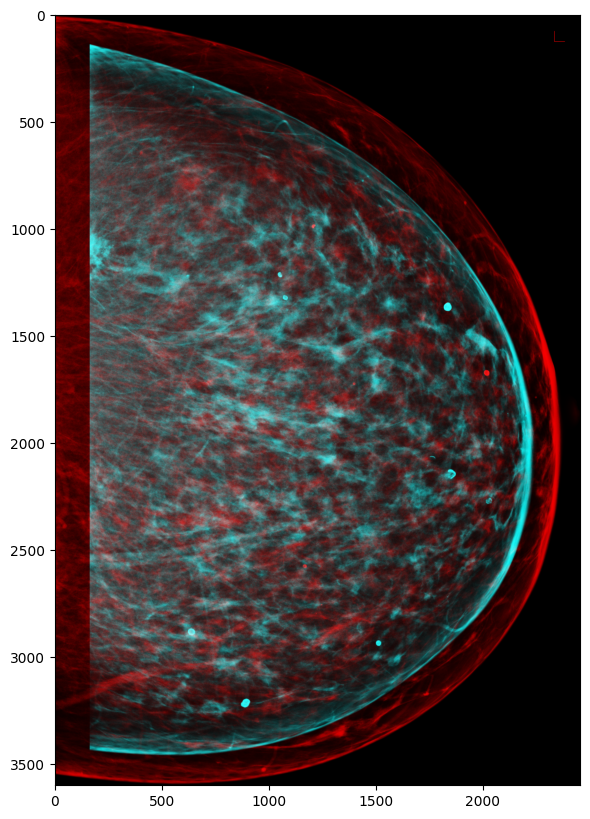

In [4]:
# Let's take a look at the dataset image
img = mmcv.imread('Dataset/training_images/demd1000_9962_1.2.826.0.1.3680043.9.3218.1.1.281768.8536.1510351239985.10145.0_CC.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Inference

In [5]:
# The arguments are the dumped config, the weights, and the output file path
!python mmdetection/tools/test.py my_configs/deformable_detr_r50_16x2_50e_coco_28e_multiview_without_diff.py output/latest.pth --out test_result_multiview_without_diff.pkl --eval bbox

/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/habtamu/MMDetection/mmdetection/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/home/habtamu/MMDetection/mmdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal perfor

Result Analysis

In [7]:
!python mmdetection/tools/analysis_tools/analyze_results.py \
       my_configs/deformable_detr_r50_16x2_50e_coco_28e_multiview_without_diff.py \
       results/test_result_multiview_without_diff.pkl \
       images \
       --show-score-thr 0.3

/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 658/658, 6.4 task/s, elapsed: 102s, ETA:     0s

### Custom Evaluation

Get ground-truth bounding boxes

In [4]:
# Load the validation annotations
ann_file = 'Dataset/validation_images/validation_annotations_multiview_without_diff.json'
coco = COCO(ann_file)

# Get the category ID for the "lesion" class
cat_id = coco.getCatIds(catNms=['lesion'])[0]

# Get the IDs of all images in the validation set
img_ids = coco.getImgIds()

gt_bboxes = []

# Loop over all images and extract the ground-truth bounding boxes
for img_id in img_ids:
    # Load the image information
    img_info = coco.loadImgs(img_id)[0]

    # Load the annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
    anns = coco.loadAnns(ann_ids)

    # Extract the bounding boxes for this image
    bboxes = []
    for ann in anns:
        bbox = ann['bbox'] # In format [x,y,width,height]
        bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] # Convert to format [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
    
    # Bounding boxes for all validation images
    gt_bboxes.append(bboxes)    

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


Non-maximum Suppression

In [5]:
def apply_nms(results, iou_threshold):
    filtered_predictions = []
    for k in range(len(results)):
        preds = np.squeeze(np.array(results[k]))
        keep = [True] * len(preds)
        for i in range(len(preds)):
            if keep[i]:
                for j in range(i + 1, len(preds)):
                    if keep[j]:
                        pred_box_i = preds[i][:4]
                        pred_box_j = preds[j][:4]
                        pred_box_tensor_i = torch.tensor([pred_box_i[0],pred_box_i[1],pred_box_i[2],pred_box_i[3]])
                        pred_box_tensor_j = torch.tensor([pred_box_j[0],pred_box_j[1],pred_box_j[2],pred_box_j[3]])
                        iou = bbox_overlaps(pred_box_tensor_i.unsqueeze(0), pred_box_tensor_j.unsqueeze(0), mode='iou', is_aligned=False)
                        if iou.item() >= iou_threshold:
                            keep[j] = False
        filtered_preds = [pred for pred, keep_pred in zip(preds, keep) if keep_pred]
        combined_preds = np.array(filtered_preds)
        filtered_predictions.append(combined_preds)
    return filtered_predictions

In [6]:
# Load the predicted boxes from the results.pkl file
results = mmcv.load('results/test_result_multiview_without_diff.pkl')
filtered_predictions= apply_nms(results, iou_threshold=0.05)

TPR vs IoU

In [7]:
post_processed = True

In [12]:
tp = np.zeros(99)
fp = np.zeros(99)
fn = np.zeros(99)
tpr = []

#thresholds = np.linspace(0, 1, 100)
# I divide values in the range [0,1] into 100 IOU thresholds
# But there is no true positive at IOU of zero
# Therefore, I started from 0.01010101 and divide values in the range [0.01010101,1] into 99 IOU thresholds
thresholds = np.linspace(0.01010101, 1, 99)

for i in range(len(gt_bboxes)):
    anns = np.squeeze(np.array(gt_bboxes[i]))
    if post_processed:
        preds = np.squeeze(np.array(filtered_predictions[i]))
    else:
        preds = np.squeeze(np.array(results[i]))

    # False positives array of size (99, number of predicted boxes)
    # If the predicted box is false positive at threshold k, 
    # the value of false_positives_arr[k, pred_box_index] will be 1.
    # Otherwise, it is zero.
    rows, cols = preds.shape
    false_positives_arr = np.zeros((99, rows))
    true_positives_arr = np.zeros((99, rows))
    for j in range(rows):
        score = preds[j][4]
        pred_box = preds[j][:4]
        
        pred_box_tensor = torch.tensor([pred_box[0],pred_box[1],pred_box[2],pred_box[3]])
        anns_tensor = torch.tensor([anns[0],anns[1],anns[2],anns[3]])
        iou = bbox_overlaps(pred_box_tensor.unsqueeze(0), anns_tensor.unsqueeze(0), mode='iou', is_aligned=False)
        #print("IoU:", iou.item())
        k = 0
        for threshold in thresholds:
            if iou.item() >= threshold:
                tp[k] = tp[k]+1
                true_positives_arr[k][j] = 1
            else:
                fp[k] = fp[k]+1
                false_positives_arr[k][j] = 1
            k = k + 1
    t = 0
    for thresh in thresholds:
        num_ones = np.sum(true_positives_arr[t] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[t] = tp[t] - false_pos
            fp[t] = fp[t] + false_pos

        if rows==0: # If there is no predicted box
            fn[t] = fn[t]+1
        elif rows==1: # If there is only one predicted box
            if false_positives_arr[t][0] == 1:
                fn[t] = fn[t]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[t] == false_positives_arr[t][0]) and false_positives_arr[t][0] == 1: 
                fn[t] = fn[t]+1
        t = t + 1

for l in range(99): 
    tpr.append(tp[l] / 658) 

TPR at the IoU threshold of 0.1

In [13]:
# Find index of IOU value closest to 0.1
iou_index = np.abs(thresholds - 0.1).argmin()

# Get corresponding TPR value
tpr_at_01_iou = tpr[iou_index]

print("TPR value for IoU of 0.1 is:", tpr_at_01_iou)

TPR value for IoU of 0.1 is: 0.9756838905775076


TPR-IoU Curve

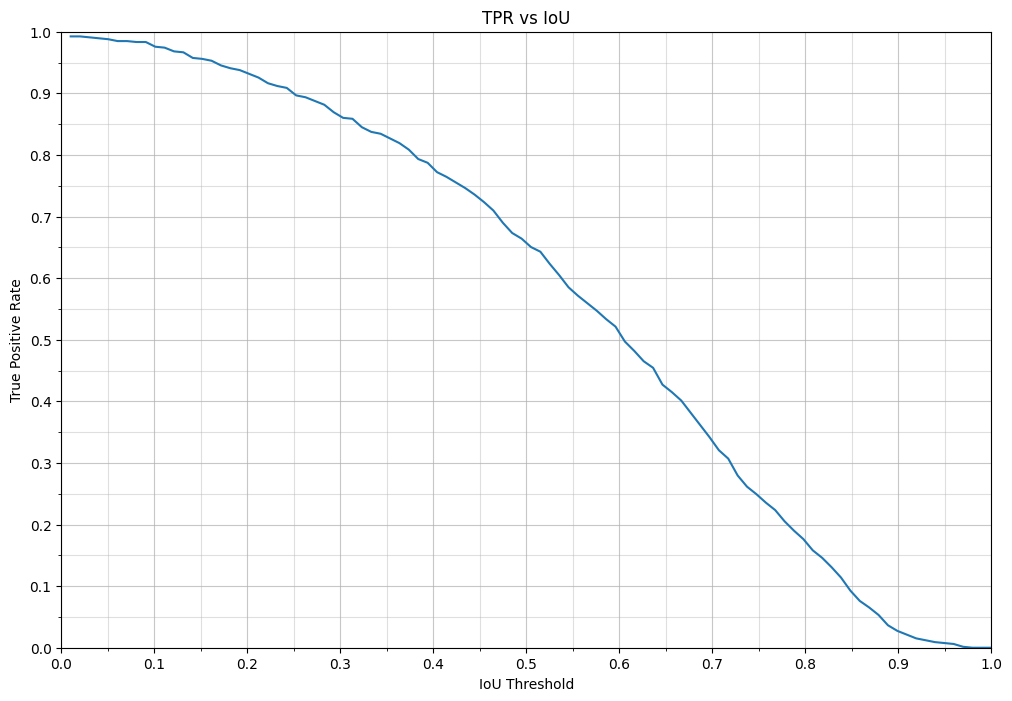

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(thresholds, tpr)
plt.xlabel("IoU Threshold")
plt.ylabel("True Positive Rate")
plt.title("TPR vs IoU")
plt.show()

TPR vs FPpI

In [8]:
tp = np.zeros(100)
fp = np.zeros(100)
fn = np.zeros(100)
tpr = []
FPpI = []

#confidence_scores = np.linspace(0.01, 1, 100)
confidence_scores = np.linspace(0, 1, 100)
IoU_thresh = 0.1

for i in range(len(gt_bboxes)):
    anns = np.squeeze(np.array(gt_bboxes[i]))
    if post_processed:
        preds = np.squeeze(np.array(filtered_predictions[i]))
    else:
        preds = np.squeeze(np.array(results[i]))

    rows, cols = preds.shape
    false_positives_arr = np.zeros((100, rows))
    true_positives_arr = np.zeros((100, rows))

    for j in range(rows):
        score = preds[j][4]
        pred_box = preds[j][:4]
        
        pred_box_tensor = torch.tensor([pred_box[0],pred_box[1],pred_box[2],pred_box[3]])
        anns_tensor = torch.tensor([anns[0],anns[1],anns[2],anns[3]])
        iou = bbox_overlaps(pred_box_tensor.unsqueeze(0), anns_tensor.unsqueeze(0), mode='iou', is_aligned=False)

        k = 0
        for conf_score in confidence_scores:
            if score >= conf_score:
                if iou.item() >= IoU_thresh:
                    tp[k] = tp[k]+1
                    true_positives_arr[k][j] = 1
                else:
                    fp[k] = fp[k]+1
                    false_positives_arr[k][j] = 1
            k = k + 1
    s = 0
    for score_thresh in confidence_scores:
        num_ones = np.sum(true_positives_arr[s] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[s] = tp[s] - false_pos
            fp[s] = fp[s] + false_pos
        
        if rows==0: # If there is no predicted box
            fn[s] = fn[s]+1
        elif rows==1: # If there is only one predicted box
            if false_positives_arr[s][0] == 1:
                fn[s] = fn[s]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[s] == false_positives_arr[s][0]) and false_positives_arr[s][0] == 1: 
                fn[s] = fn[s]+1
        s = s + 1
for l in range(100): 
    if tp[l] == 0 and fn[l] == 0: # To avoid zero division problem
        tpr.append(0)
    else:
        tpr.append(tp[l] / 658) 
    FPpI.append(fp[l]/len(gt_bboxes))

TPR at 0.75, 0.8, and 0.85 FPpI

In [9]:
FPpI_np = np.array(FPpI)
tpr_np = np.array(tpr)

def compute_tpr_at_target_FPpI(target):

    # Find the index of the element closest to the target
    index = np.abs(FPpI_np - target).argmin()

    # Check if the value at the returned index is already equal to the target
    if FPpI_np[index] == target:
        return tpr[index]
    
    else:
        # Determine the closest values based on the index
        if FPpI_np[index] < target:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_np[lower_index]
        x2 = FPpI_np[upper_index]
        y1 = tpr[lower_index]
        y2 = tpr[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (target - x1)
        return y
    
tpr_at_075_FPpI = compute_tpr_at_target_FPpI(0.75)
tpr_at_08_FPpI = compute_tpr_at_target_FPpI(0.8)
tpr_at_085_FPpI = compute_tpr_at_target_FPpI(0.85)

print("TPR value for FPpI of 0.75 is:", tpr_at_075_FPpI)
print("TPR value for FPpI of 0.8 is:", tpr_at_08_FPpI)
print("TPR value for FPpI of 0.85 is:", tpr_at_085_FPpI)

TPR value for FPpI of 0.75 is: 0.8731003039513678
TPR value for FPpI of 0.8 is: 0.871631205673759
TPR value for FPpI of 0.85 is: 0.8755274450205615


The FROC

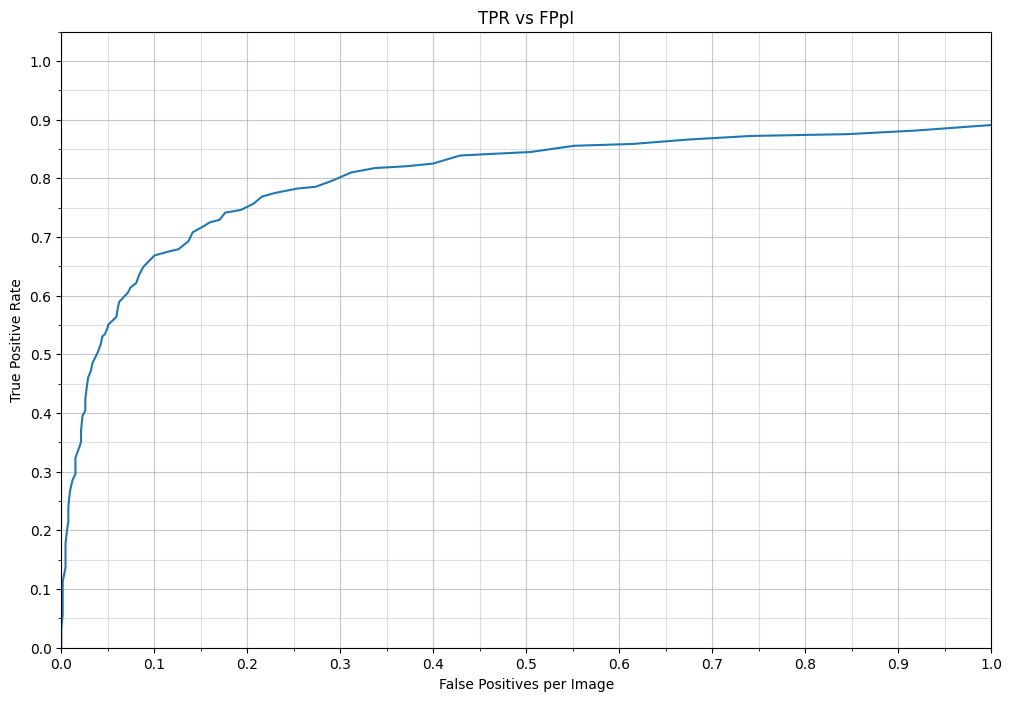

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(FPpI, tpr)
plt.xlabel("False Positives per Image")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPpI")
plt.show()

Area Under the FROC

In [11]:
# Reverse order from descending to ascending
tpr_reversed = np.flip(tpr_np)
FPpI_reversed = np.flip(FPpI_np)

def compute_auc():

    # Find the index of the element closest to 1.0
    index = np.abs(FPpI_reversed - 1.0).argmin()

    # Check if the value at the returned index is already equal to 1.0
    if FPpI_reversed[index] == 1.0:
        # Select portion of TPR and FPpI
        tpr_portion = tpr_reversed[:index+1]
        FPpI_portion = FPpI_reversed[:index+1]
    
    else:
        # Determine the closest values based on the index
        if FPpI_reversed[index] < 1.0:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_reversed[lower_index]
        x2 = FPpI_reversed[upper_index]
        y1 = tpr_reversed[lower_index]
        y2 = tpr_reversed[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (1.0 - x1)
        tpr_portion = tpr_reversed[:lower_index+1]
        FPpI_portion = FPpI_reversed[:lower_index+1]

        # Adding y to the end of the tpr_portion array
        tpr_portion = np.append(tpr_portion, y)
        FPpI_portion = np.append(FPpI_portion, 1.0)
        froc_auc = metrics.auc(FPpI_portion, tpr_portion)
        return froc_auc
    
print("Area under the FROC:", compute_auc())

Area under the FROC: 0.799325217519842
